In [299]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import matplotlib.pyplot as plt

import jax
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', True)
import jax.numpy as jnp
import jax.scipy.stats as jss

from jax.random import split

from data import get_posteriors
from data import get_injections

from bilby_util import convert_bilby_uniform_prior

from models import build_interp_sampler
from models import truncnorm
from models import iso_gauss_spin_tilt
from models import log_powerlaw_redshift
from pixelpop.models.gwpop_models import BrokenPowerLaw
from pixelpop.models.gwpop_models import PowerlawPlusPeak_MassRatio
from pixelpop.models.gwpop_models import BrokenPowerlawPlusTwoPeaks_PrimaryMass

from likelihood import taper
from likelihood import shape_ln_likelihood_and_variance

from flows import default_flow
from variational import fit
from variational import estimate_convergence

from util import plot_loss
from util import plot_multiple
from util import monotonic_select

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seconds_per_day = 86_400 # [ s / day ]
days_per_year = 365

grav_constant = 1.3e20 #* seconds_per_day**2 # [meters^3 / sec^2 / Msun]
speed_of_light = 3e8 #* seconds_per_day # [meters / sec]

## inspect one distribution

In [3]:
def remnant_mass_golomb2023(mprog, mbhmax, mturnover):
    return monotonic_select(
        jnp.array([mturnover, 2 * mbhmax - mturnover]),
        jnp.array([
            mprog,
            mbhmax + (mprog - 2 * mbhmax + mturnover)**2 / 4 / (mturnover - mbhmax),
            0.0
        ])
    )(mprog)

In [74]:
def sample_mbh_given_mprog_golomb2023(key, mprog, mbhmax, mturnover, sigma_mbh):
    mean_mbh = remnant_mass_golomb2023(mprog, mbhmax, mturnover)
    ln_mbh = jax.random.normal(key) * sigma_mbh + jnp.log(mean_mbh)
    return jnp.exp(ln_mbh)

In [31]:
def log_bpl_progenitor_mass(mprog, alpha_1, alpha_2, mmin, mmax, mbreak):
    break_fraction = (mbreak - mmin) / (mmax - mmin)
    return BrokenPowerLaw(mprog, -alpha_1, -alpha_2, mmin, mmax, break_fraction)

In [57]:
ms = jnp.linspace(3, 80, 500)
sample_mprog = build_interp_sampler(
    lambda x: jnp.exp(log_bpl_progenitor_mass(
        x,
        2, #parameters['alpha_prog_1'],
        1.01, #parameters['alpha_prog_2'],
        3, #parameters['mprog_min'],
        80, #parameters['mprog_max'],
        20,
    )),
    ms
)

In [60]:
keys = split(jax.random.key(1), 10_000)
mprogs = jax.vmap(sample_mprog)(keys)

(5.0, 80.0)

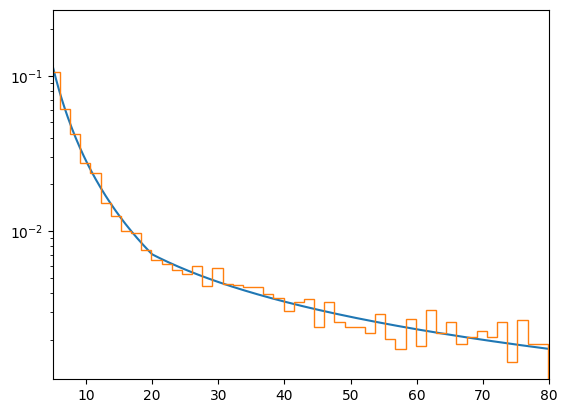

In [64]:
fig, ax = plt.subplots()

ms = jnp.linspace(5, 80, 500)
log_p = log_bpl_progenitor_mass

ax.plot(ms, jnp.exp(log_bpl_progenitor_mass(ms, 2, 1.01, 3, 80, 20)))
ax.hist(mprogs, bins=50, histtype='step', density=True)

ax.semilogy()

ax.set_xlim(5, 80)

In [75]:
keys = split(jax.random.key(2), 10_000)
mbhs = jax.vmap(
    lambda x: sample_mbh_given_mprog_golomb2023(x[0], x[1], 45, 30, 0.04)
)((keys, mprogs))

In [78]:
def log_bpl_2p_primary_mass(dataset, parameters):
    lam_tilde_0 = parameters['lam_tilde_0']
    lam_tilde_1 = parameters['lam_tilde_1']
    lam_tilde_2 = parameters['lam_tilde_2']

    norm = lam_tilde_0 + lam_tilde_1 + lam_tilde_2
    parameters['lam0'] = lam_tilde_0 / norm
    parameters['lam1'] = lam_tilde_1 / norm
    parameters['lam2'] = lam_tilde_2 / norm

    return BrokenPowerlawPlusTwoPeaks_PrimaryMass(
        dataset,
        alpha_1=parameters['alpha1'],
        alpha_2=parameters['alpha2'],
        mmin=parameters['mmin'],
        break_mass=parameters['mbreak'],
        delta_m_1=parameters['delta_m'],
        lam_fractions=[
            parameters['lam0'],
            parameters['lam1'],
            parameters['lam2']
        ],
        mpp_1=parameters['mpp1'],
        sigpp_1=parameters['sigpp1'],
        mpp_2=parameters['mpp2'],
        sigpp_2=parameters['sigpp2'],
    )

In [285]:
def draw_maxwellian_velocity(key, rms):
    x = jax.random.normal(key, (3,))
    return x * rms


def beefy_term(beta, u_vec):
    ux, uy, uz = u_vec 
    return 2 * beta - ux**2 - (uy + 1)**2 - uz**2

def calc_relative_semimajoraxis(beta, u_vec):
    numer = beta
    denom = beefy_term(beta, u_vec)
    return numer / denom


def calc_1me2(beta, u_vec):
    _, uy, uz = u_vec
    numer = (uz**2 + (uy + 1)**2) * beefy_term(beta, u_vec)
    denom = beta**2
    return numer / denom


def calc_cos_theta(u_vec):
    _, uy, uz = u_vec
    numer = uy + 1
    denom = jnp.sqrt(uz**2 + (uy + 1)**2)
    return numer / denom


def calc_orbital_decay_time(a, m1, m2):
    """ From Peters (1964), Eq. (5.10) -- time [days] for orbit to decay """
    prefactor = 64 / 5 * grav_constant**3 / speed_of_light**5
    beta = prefactor * m1 * m2 * (m1 + m2)
    return a**4 / 4 / beta

# from: https://arxiv.org/abs/2010.16333
period_min = 0.4 # [ days ]
period_max = 10**(5.5) # [ days ]

def get_sample(key, parameters):
    ms = jnp.linspace(
        3, #parameters['mprog_min'],
        80, #parameters['mprog_max'],
        500
    )

    sample_mprog = build_interp_sampler(
        lambda x: jnp.exp(log_bpl_progenitor_mass(
            x,
            parameters['alpha_prog_1'],
            parameters['alpha_prog_2'],
            3, #parameters['mprog_min'],
            80, #parameters['mprog_max'],
            20,
        )),
        ms
    )

    # sample mprog
    key, subkey = split(key)
    mprog1 = sample_mprog(subkey)

    key, subkey = split(key)
    mbh1 = sample_mbh_given_mprog_golomb2023(
        subkey, mprog1, parameters['mbhmax'], parameters['mturnover'], parameters['sigma_mbh']
    )

    key, subkey = split(key)
    mprog2 = sample_mprog(subkey)

    key, subkey = split(key)
    mbh2 = sample_mbh_given_mprog_golomb2023(
        subkey, mprog2, parameters['mbhmax'], parameters['mturnover'], parameters['sigma_mbh']
    )

    mtot_i = mbh1 + mprog2
    mtot_f = mbh1 + mbh2

    beta = mtot_f / mtot_i

    gmi = grav_constant * mtot_i

    key, subkey = split(key)
    log_period_days = jax.random.uniform(
        subkey, minval=jnp.log(period_min), maxval=jnp.log(period_max)
    ) # [days] # TBD: period bounds!
    period_sec_squared = jnp.exp(2 * (log_period_days + jnp.log(seconds_per_day)))

    ai = (period_sec_squared * gmi / 4 / jnp.pi**2)**(1 / 3) # kepler's 3rd law! in units of [m]

    # TODO: here we assume r = a...but instead we should marginalize over orbital phase!
    # or at least compare!
    # well...oth...if we assume a circular orbit, r = a always
    # vorb^2 = G * mtot * (2 / r - 1 / a)
    vorb = jnp.sqrt(gmi / ai)
 
    key, subkey = split(key)
    vkick_vec = draw_maxwellian_velocity(subkey, parameters['sigma_kick'])
    u_vec = vkick_vec / vorb

    alpha = calc_relative_semimajoraxis(beta, u_vec)
    ome2 = calc_1me2(beta, u_vec)
    ecc2 = 1 - ome2
    ecc = jnp.sqrt(ecc2)
    cos_theta = calc_cos_theta(u_vec)

    survive = (alpha > 0) & (ecc < 1) & (mbh2 > 0)

    af = ai / alpha
    decay_time = calc_orbital_decay_time(af, mbh1, mbh2)

    merge = decay_time / seconds_per_day / days_per_year < 14e9
    
    return dict(
        mprog1=mprog1,
        mprog2=mprog2,
        mbh1=mbh1,
        mbh2=mbh2,
        beta=beta,
        log_period=log_period_days,
        alpha=alpha,
        ai=ai,
        af=af,
        vorb=vorb,
        vkick_vec=vkick_vec,
        u_vec=u_vec,
        ecc=ecc,
        cos_theta=cos_theta,
        decay_time=decay_time,
        survive=survive,
        merge=merge,
    )

In [246]:
parameters = dict(
    mbhmax=45, #50,
    mturnover=5, #34,
    sigma_mbh=0.04,
    alpha_prog_1=2, #3,
    alpha_prog_2=1.01, #0.2,
    #alpha1=1.81, #3.4,
    #alpha2=4.16, #3.4,
    #mpp1=9.20, #10,
    #sigpp1=0.79, #3,
    #mpp2=33.83,#34,
    #sigpp2=2.65,#3.6,
    #mmin=6.72, #5,
    #delta_m=7.63, #4.8,
    #mbreak=32.51, #50,
    #lam_tilde_0=0.11, #0.6,
    #lam_tilde_1=0.88, #0.3,
    #lam_tilde_2=0.01,#0.1,
    sigma_kick=1e4,
    xi_spin=0.1
)

In [286]:
samples = jax.vmap(lambda k: get_sample(k, parameters))(split(jax.random.key(1), 1_000_000))

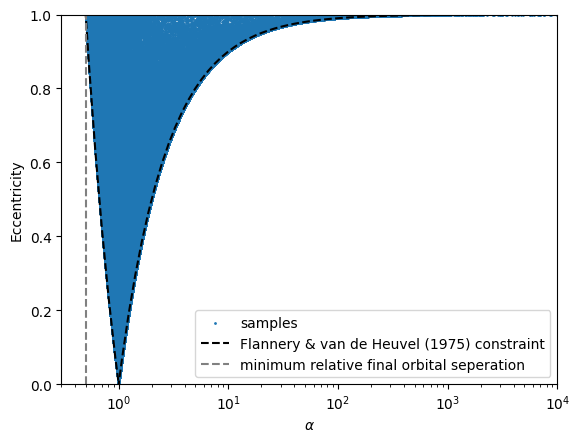

In [260]:
mask = samples['alpha'] > 0

fig, ax = plt.subplots()
ax.scatter(
    samples['alpha'][mask],
    samples['ecc'][mask],
    s=1,
    label='samples'
)

xs = jnp.logspace(-1, 5, 100)

ys = 1 / xs - 1
ax.plot(xs, ys, color='black', linestyle='--', label='Flannery & van de Heuvel (1975) constraint')

ys = 1 - 1 / xs
ax.plot(xs, ys, color='black', linestyle='--')

ax.axvline(x=0.5, color='grey', linestyle='--', label='minimum relative final orbital seperation')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'Eccentricity')
ax.semilogx()

ax.set_ylim(0, 1)
ax.set_xlim(0.3, 1e4)

ax.legend()

In [ ]:
mask = samples['survive'] & samples['merge']

In [263]:
jnp.sum(mask) / len(mask)

Array(0.128235, dtype=float64)

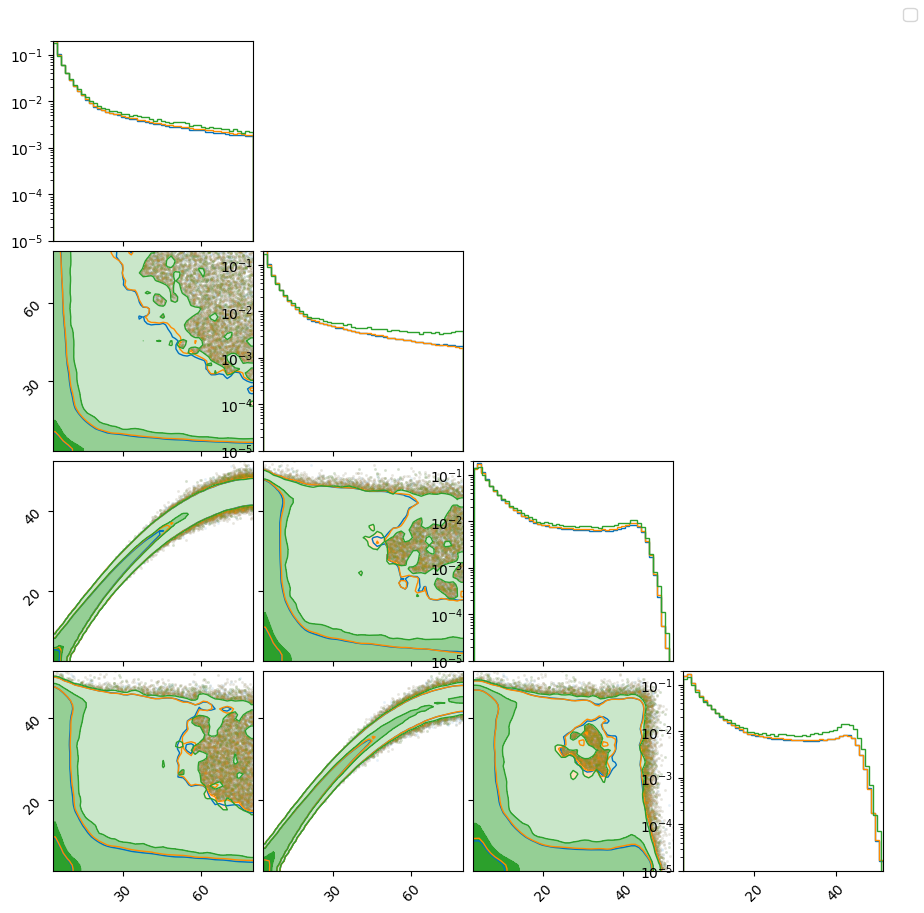

In [303]:
x = jnp.column_stack((
    samples['mprog1'],
    samples['mprog2'],
    samples['mbh1'],
    samples['mbh2']
))

fig = plot_multiple([x, x[samples['survive']], x[mask]])

for i in [0, 5, 10, 15]:
    ax = fig.get_axes()[i]
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 2e-1)

Text(0, 0.5, 'density')

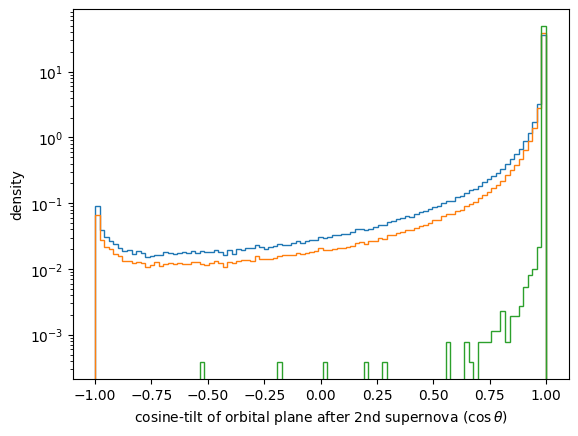

In [294]:
bins = jnp.linspace(-1, 1, 100)
ks = dict(histtype='step', bins=bins, density=True)

fig, ax = plt.subplots()
ax.hist(samples['cos_theta'], label='all binaries', **ks)
ax.hist(samples['cos_theta'][samples['survive']], label='non-disrupted binaries', **ks)
ax.hist(samples['cos_theta'][mask], label='non-disrupted binaries that merge in 14 Gyr', **ks)
ax.semilogy()

ax.set_xlabel(r'cosine-tilt of orbital plane after 2nd supernova ($\cos \theta$)')
ax.set_ylabel('density')

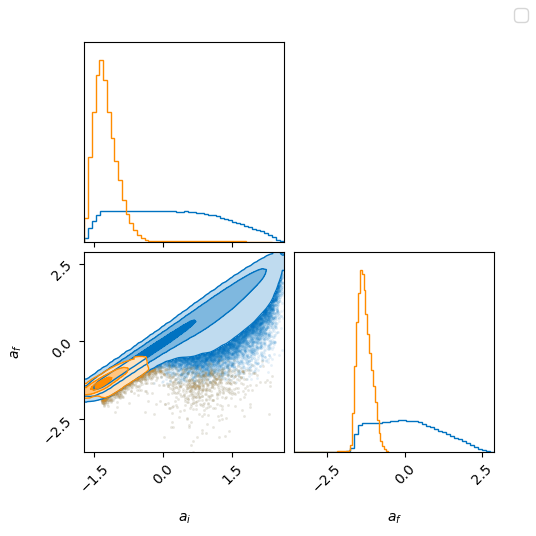

In [284]:
from util import plot_corner, plot_multiple

meters_per_au = 1.5e11

xs = jnp.column_stack((
    samples['ai'] / meters_per_au,
    samples['af'] / meters_per_au
))


fig = plot_multiple(
    [
        jnp.log10(xs[samples['survive']]),
        jnp.log10(xs[mask]),
    ],
    labels=[r'$a_i$', r'$a_f$']
    #labels=[r'$\cos \theta$', r'$\log_{10} v_{\rm orb}$ [$\mathrm{km}\,\mathrm{s}^{-1}$]', r'$\log_{10} |\vec{u}|$', r'$\log_{10} P$ [days]']
)

#ax = fig.get_axes()[0]
#ax.set_yscale('log')
#ax.set_ylim(1e-5, 1e2)


(1e-05, 100.0)

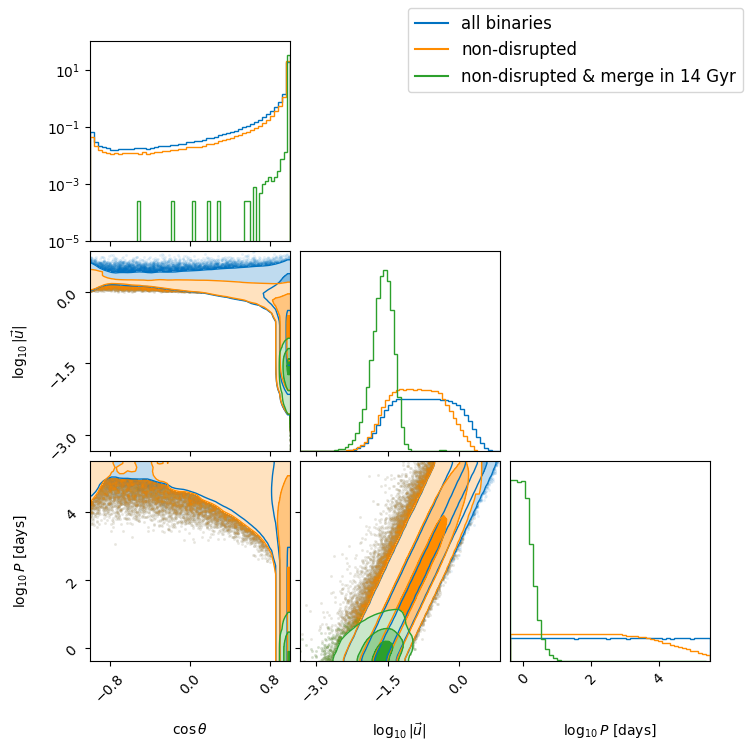

In [297]:
from util import plot_corner, plot_multiple

xs = jnp.column_stack((
    samples['cos_theta'],
    #jnp.log10(samples['vorb'] / 1e3),
    jnp.log10(jnp.sqrt(jnp.sum(samples['u_vec']**2, axis=-1))), #samples['u_vec']
    samples['log_period'] / jnp.log(10)
))


fig = plot_multiple(
    [xs, xs[samples['survive']], xs[mask]],
    labels=[
        r'$\cos \theta$',
        #r'$\log_{10} v_{\rm orb}$ [$\mathrm{km}\,\mathrm{s}^{-1}$]',
        r'$\log_{10} |\vec{u}|$',
        r'$\log_{10} P$ [days]'
    ],
    xs_labels=['all binaries', 'non-disrupted', 'non-disrupted & merge in 14 Gyr']
)

ax = fig.get_axes()[0]
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e2)


## learn cos tilt distribution conditioned on hyperparameters

In [ ]:
from flows import bound_from_unbound
from flowjax.distributions import StandardNormal, Uniform
from flowjax.bijections import RationalQuadraticSpline
from flowjax.flows import coupling_flow

interval = (-1, 1)

base_dist = Uniform(
    minval=interval[0] * jnp.ones((1,)),
    maxval=interval[1] * jnp.ones((1,))
)

default_kwargs = dict(
    key=jax.random.key(1),
    base_dist=base_dist, #StandardNormal(shape=(1,)),
    invert=False,
    nn_depth=1,
    nn_width=10,
    flow_layers=1,
    cond_dim=1
)

transformer = RationalQuadraticSpline(knots=5, interval=interval)
cos_tau_prior_init = coupling_flow(transformer=transformer, **default_kwargs)
#cos_tau_prior_init = bound_from_unbound(cos_tau_prior_init, [[-1, 1]])

In [ ]:
param_keys, bounds, log_prior = convert_bilby_uniform_prior('./kick-prog.prior')

We're going to infer the population-level distribution of the supernova kick magnitude *relative to orbital velocity*, $u = \frac{V_{\rm kick}}{V_{\rm orb}}$.

(To back out a physical $V_{\rm kick}$ for the second-born black hole, we'd need to know/assume the pre-supernova total mass of the binary.)

We model the kicks as drawn from a Maxwellian distribution ($\propto u^2 \exp\left[ -u^2 / \sigma_{\rm kick}^2 \right]$).

We'll assume $p(\sigma_{\rm kick})$ is uniform on $[0.1, 1]$---note that the allowed distributions of spin tilts will be very sensitive to the bounds on this prior!

Note that, for simplicity, I'm *not* enforcing any additional cut in the kick magnitude distribution based on survivability, as this requires extra information about the progenitor binary.

In [2]:
param_keys, bounds, log_prior = convert_bilby_uniform_prior('./kick.prior')

From Kalogera (1996), we compute the tilt $\theta$ of the orbital plane following the second supernova in the binary as:

$$ \cos \theta = \frac{u_{y} + 1}{\sqrt{ u_z^2 + (u_y + 1)^2 }} $$

where $u_y, u_z$ are the $y$ and $z$ components of the kick velocity (note the orbital velocity lies in the $x-y$ plane by construction).

Below, we draw $u = \sqrt{u_x^2 + u_y^2 + u_z^2}$ from a Maxwellian distribution with various $\sigma_{\rm kick}$, and study the $\cos \theta$ distributions induced by these different kick distributions.

In [5]:
def get_sample(key, sigma_kick):
    """ Draw the squared kick magnitude from a Maxwellian, and compute """
    key, subkey = jax.random.split(key)
    u = jax.random.normal(subkey, (3,))
    u = u * sigma_kick
    ux, uy, uz = u

    u2 = jnp.sum(ux**2 + uy**2 + uz**2)

    cos_tau = (uy + 1) / jnp.sqrt(uz**2 + (uy + 1)**2)

    return jnp.sqrt(u2), cos_tau

Look how peaky the $\cos \theta$ distribution is unless the kick magnitude distributions extends to high values!

Text(0, 0.5, 'count')

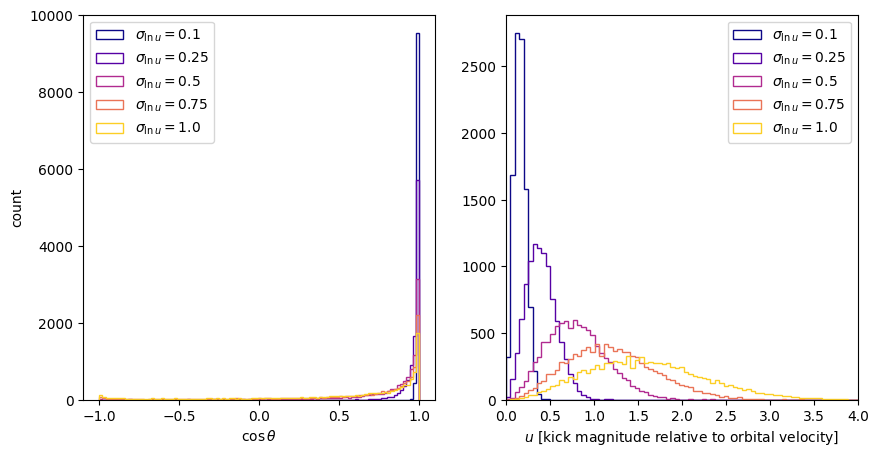

In [9]:
from matplotlib.colors import Normalize

sigs = jnp.array([0.1, 0.25, 0.5, 0.75, 1])

cmap = plt.get_cmap('plasma')
norm = Normalize(vmin=sigs.min(), vmax=sigs.max() * 1.1)

hs = dict(histtype='step')

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for sig in sigs:
    u, s = jax.vmap(
        lambda k: get_sample(k, sig)
    )(jax.random.split(jax.random.key(1), 10_000))
    label = r'$\sigma_{\ln u} =' + f'{sig}' + '$'
    axes[0].hist(s, label=label, color=cmap(norm(sig)), bins=jnp.linspace(-1, 1, 100), **hs)
    axes[1].hist(u, label=label, color=cmap(norm(sig)), bins=jnp.linspace(0, 5, 100), **hs)

axes[1].set_xlim(0, 4)

for ax in axes.flat:
    ax.legend()

axes[0].set_xlabel(r'$\cos \theta$')
axes[1].set_xlabel(r'$u$ [kick magnitude relative to orbital velocity]')

axes[0].set_ylabel('count')

For the rest of our population model, we'll use the default population model & priors from the O4a populations paper, namely:

- Broken power law + 2 peaks in $m_1$
- Powerlaw in $q$
- Powerlaw in merger-rate density as a function of redshift
- Independent & identical truncated Gaussians in spin magnitudes, $a_1$ and $a_2$

(This next section could be titled "When you have a hammer everything looks like a nail")

For the tilts $\vec{\tau} = [\tau_1, \, \tau_2]^T$, we're going to assume a mixture between an isotropic distribution and a distribution induced by kick magnitudes.

We're going to assume that the component tilts are drawn from the same distribution---which is wrong, but again, simple for a first test.

The distribution for a particular component tilt induced by the kick distribution is:

$$p_{\rm kick}(\cos \tau | \sigma_{\rm kick}) = \int \, du_x \, du_y \, du_z \, p(\cos \tau | u_y, u_z) p(u_x, u_y, u_z | \sigma_{\rm kick})$$

When mixed with our isotropic component, we have:

$$ p(\cos \vec{\tau} | \xi, \sigma_{\rm kick}) = \frac{1 - \xi}{4} + \xi p_{\rm kick}(\cos \tau_1 | \sigma_{\rm kick}) p_{\rm kick}(\cos \tau_2 | \sigma_{\rm kick}) $$

Note that

$$ p(\cos \tau | u_y, u_z) = \delta( \cos \tau - \cos \tau(u_y, u_z) ) $$

but that the relationship between kick vector and $\cos \tau$ is a many-to-one map. Therefore, we instead use simulation-based inference to learn the distribution $p_{\rm kick}(\cos \tau | \sigma_{\rm kick})$ given $\sigma_{\rm kick}$.

In [10]:
sigma_kick_min, sigma_kick_max = bounds[param_keys.index('sigma_kick')]

In [11]:
from flows import bound_from_unbound
from flowjax.distributions import StandardNormal, Uniform
from flowjax.bijections import RationalQuadraticSpline
from flowjax.flows import coupling_flow

interval = (-1, 1)

base_dist = Uniform(
    minval=interval[0] * jnp.ones((1,)),
    maxval=interval[1] * jnp.ones((1,))
)

default_kwargs = dict(
    key=jax.random.key(1),
    base_dist=base_dist, #StandardNormal(shape=(1,)),
    invert=False,
    nn_depth=1,
    nn_width=10,
    flow_layers=1,
    cond_dim=1
)

transformer = RationalQuadraticSpline(knots=5, interval=interval)
cos_tau_prior_init = coupling_flow(transformer=transformer, **default_kwargs)
#cos_tau_prior_init = bound_from_unbound(cos_tau_prior_init, [[-1, 1]])

In [12]:
import equinox as eqx
import optax
from paramax import NonTrainable
from jax_tqdm import scan_tqdm

def train_cos_tau_prior(
    key,
    flow,
    steps,
    optimizer=None,
    batch_size=1,
):
    params, static = eqx.partition(
        pytree=flow,
        filter_spec=eqx.is_inexact_array,
        is_leaf=lambda leaf: isinstance(leaf, NonTrainable),
    )

    def get_sample(key):
        key, subkey = jax.random.split(key)
        sigma_kick = jax.random.uniform(subkey) * (
            sigma_kick_max - sigma_kick_min
        ) + sigma_kick_min

        key, subkey = jax.random.split(key) 
        u = jax.random.normal(subkey, (3,))
        u = u * sigma_kick
        ux, uy, uz = u

        cos_tau = (uy + 1) / jnp.sqrt(uz**2 + (uy + 1)**2)

        return jnp.array([cos_tau]), jnp.array([sigma_kick])

    def get_batch(key):
        keys = jax.random.split(key, batch_size)
        return jax.vmap(get_sample)(keys)

    def loss_fn(params, key, step):
        flow = eqx.combine(params, static)
        batch = get_batch(key)
        log_q = jax.vmap(
            lambda x: flow.log_prob(x[0], condition=x[1])
        )(batch)
        return -jnp.mean(log_q)
   
    state = optimizer.init(params)

    @scan_tqdm(steps, desc='train')
    @eqx.filter_jit
    def update(carry, step):
        key, params, state = carry
        key, _key = jax.random.split(key)
        loss, grad = eqx.filter_value_and_grad(loss_fn)(params, _key, step)
        updates, state = optimizer.update(grad, state, params)
        params = eqx.apply_updates(params, updates)
        return (key, params, state), loss

    (key, params, state), losses = jax.lax.scan(
        update, (key, params, state), jnp.arange(steps),
    )
    flow = eqx.combine(params, static)

    return flow, losses


In [13]:
lr = 1e-3
steps = 10_000

learning_rate = optax.warmup_cosine_decay_schedule(
    init_value=lr,
    peak_value=lr,
    warmup_steps=0,
    decay_steps=steps,
    end_value=lr
)

optimizer = optax.adam(learning_rate=learning_rate)

cos_tau_prior, loss = train_cos_tau_prior(jax.random.key(12), cos_tau_prior_init, steps, optimizer, batch_size=10_000)

train: 100%|██████████| 10000/10000 [00:02<00:00, 4163.43it/s]


Great! Maybe we've learned $p(\cos \tau | \sigma_{\rm kick})$. To be checked in future how well our machine-learning has approximated this distribution!

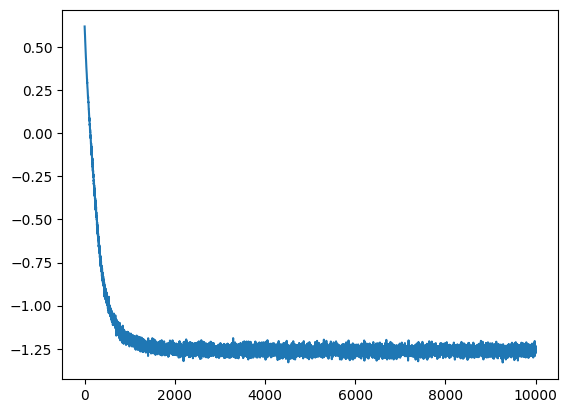

In [15]:
plot_loss(loss);

Now we set up our population inference code!

In [16]:
def kick_tilt_model(cos_tau, parameters):
    sig = parameters['sigma_kick']
    condition = jnp.array([sig])

    def fn(x):
        return jnp.exp(
            cos_tau_prior.log_prob(jnp.array([x]), condition=condition)
        )

    def vmap(x):
        if x.ndim == 1:
            return jax.lax.map(fn, x, batch_size=100_000) #jax.vmap(base_scalar, in_axes=0)(x)
        elif x.ndim == 2:
            #return jax.lax.map(
            #    lambda r: jax.vmap(base_scalar)(r), #jax.lax.map(base_scalar, r, batch_size=10), ,
            #    x,
            #    batch_size=10
            #)
            #return jax.lax.map(jax.vmap(base_scalar, in_axes=0),    ) #jax.vmap(jax.vmap(base_scalar, in_axes=0), in_axes=0)(x)
            return jax.vmap(lambda r: jax.vmap(fn)(r))(x)
        else:
            raise ValueError(f"Expected 1D or 2D, got {x.shape}")

    #p1 = vmap(dataset['cos_tilt_1'])
    #p2 = vmap(dataset['cos_tilt_2'])

    #return p1 * p2

    return vmap(cos_tau)

In [17]:
def full_tilt_model(dataset, parameters):
    xi_spin = parameters['xi_spin']

    p_kick_tilt = kick_tilt_model(dataset['cos_tilt_1'], parameters)
    p_kick_tilt *= kick_tilt_model(dataset['cos_tilt_2'], parameters)
    p_iso = 1 / 4

    return (1 - xi_spin) * p_iso + xi_spin * p_kick_tilt

In [18]:
def model_kick(dataset, parameters):
    lam_tilde_0 = parameters['lam_tilde_0']
    lam_tilde_1 = parameters['lam_tilde_1']
    lam_tilde_2 = parameters['lam_tilde_2']

    norm = lam_tilde_0 + lam_tilde_1 + lam_tilde_2
    parameters['lam0'] = lam_tilde_0 / norm
    parameters['lam1'] = lam_tilde_1 / norm
    parameters['lam2'] = lam_tilde_2 / norm

    #p_m1qzmag = bplm1q_plz_truncnormmag(dataset, parameters)

    log_p_m1 = BrokenPowerlawPlusTwoPeaks_PrimaryMass(
        dataset,
        alpha_1=parameters['alpha1'],
        alpha_2=parameters['alpha2'],
        mmin=parameters['mmin'],
        break_mass=parameters['mbreak'],
        delta_m_1=parameters['delta_m'],
        lam_fractions=[
            parameters['lam0'],
            parameters['lam1'],
            parameters['lam2']
        ],
        mpp_1=parameters['mpp1'],
        sigpp_1=parameters['sigpp1'],
        mpp_2=parameters['mpp2'],
        sigpp_2=parameters['sigpp2'],
    )
    p_m1 = jnp.exp(log_p_m1)

    log_p_q = PowerlawPlusPeak_MassRatio(
        dataset,
        slope=parameters['beta'],
        minimum=parameters['mmin'],
        delta_m=parameters['delta_m']
    )
    p_q = jnp.exp(log_p_q)

    log_p_z = log_powerlaw_redshift(dataset, parameters)
    p_z = jnp.exp(log_p_z)

    p_a1 = truncnorm(
        dataset['a_1'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )
    p_a2 = truncnorm(
        dataset['a_2'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )

    p_tilt = full_tilt_model(dataset, parameters)

    return p_m1 * p_q * p_z * p_a1 * p_a2 * p_tilt

In [19]:
import pickle

datadir = '/n/netscratch/iaifi_lab/Lab/newolfe/tilts-and-kicks'
with open(f'{datadir}/posteriors.pkl', 'rb') as f:
    posteriors = pickle.load(f)

posteriors = {k : jnp.array(v) for k, v in posteriors.items()}

with open(f'{datadir}/injections.pkl', 'rb') as f:
    injections = pickle.load(f)

injections = {k : jnp.array(v) for k, v in injections.items()}

In [20]:
maximum_variance = 1

def log_likelihood(parameters):
    parameters = dict(zip(param_keys, parameters))
    lkl, var, _, _, _ = shape_ln_likelihood_and_variance(
        posteriors, injections, model_kick, parameters
    )
    return lkl, var


def log_posterior(parameters):
    lkl, var = log_likelihood(parameters)
    return lkl + taper(maximum_variance, var) + log_prior(parameters)

In [21]:
flow_init = default_flow(jax.random.key(1), bounds)

Variational inference allows us to get a represenative (though not fully converged) estimate of the population posterior with only $10^4$ likelihood evaluations.

In [23]:
flow, loss = fit(jax.random.key(2), flow_init, log_posterior, steps=1_000, batch_size=10)

train: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


Loss curve of variational inference -- lower is better, although we don't have the evidence $Z$ a-priori, so it won't go to zero. Instead, it should plateau at some value $\sim -\ln Z$.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

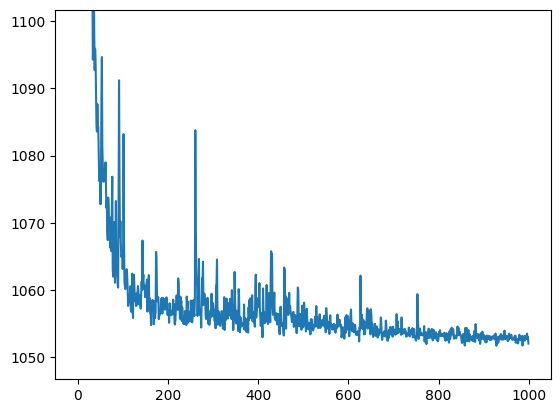

In [24]:
plot_loss(loss, zoom=True)

In [25]:
from variational import sample_and_log_prob
samples, log_q = sample_and_log_prob(jax.random.key(11), flow, n=10_000)

In [30]:
lkl, var = jax.lax.map(
    log_likelihood,
    samples,
    batch_size=100
)

In [26]:
samples_dict = dict(zip(param_keys, samples.T))

In [33]:
samples_dict['variance'] = var

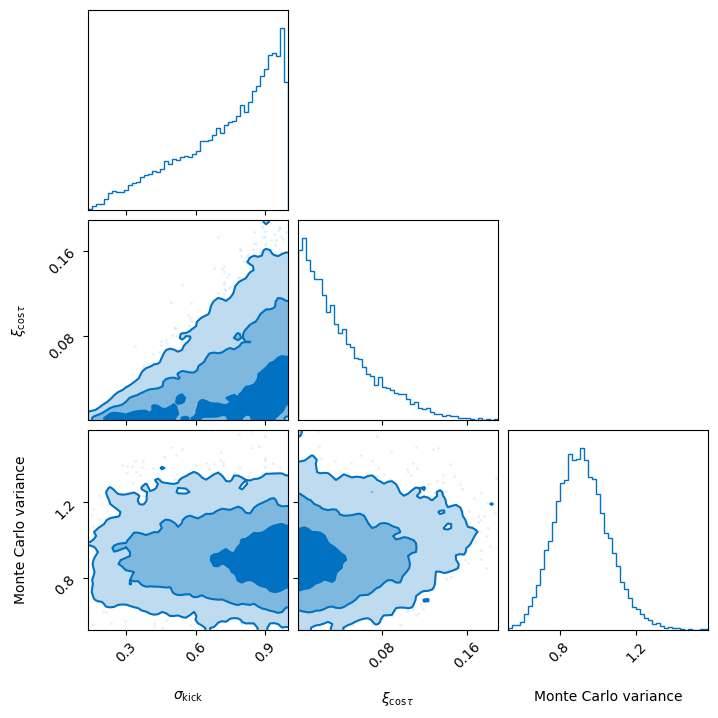

In [34]:
from util import plot_corner

plot_keys = ['sigma_kick', 'xi_spin', 'variance']
labels = [r'$\sigma_{\rm kick}$', r'$\xi_{\cos \tau}$', r'Monte Carlo variance']

fig = plot_corner(
    jnp.column_stack([ samples_dict[k] for k in plot_keys ]),
    labels=labels,
)

In [28]:
def p_cos_tau(x, parameters):
    xi_spin = parameters['xi_spin']
    return (1 - xi_spin) / 2 + xi_spin * kick_tilt_model(x, parameters)

In [29]:
cts = jnp.linspace(-1, 1, 1_000)
p_ct = jax.vmap(lambda p: p_cos_tau(cts, p))(samples_dict)

We get a very peaky $\cos \tau$ distribution!

Filled area is the 90% credible region, solid line is the median.

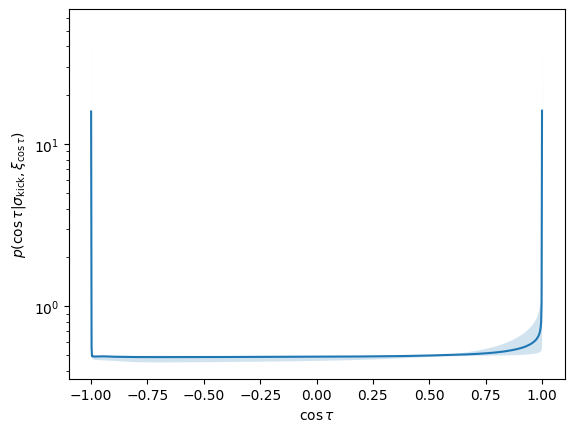

In [56]:
from plots import add_ppd

fig, ax = plt.subplots()
add_ppd(cts, p_ct, ax, color='C0', fill=True, quantiles=[(0.05, 0.95)], alpha=0.2)
ax.set_yscale('log')

ax.set_ylabel(r'$p(\cos \tau | \sigma_{\rm kick}, \xi_{\cos \tau})$')
ax.set_xlabel(r'$\cos \tau$');

If we restrict ourselves to $\cos \tau \in (-1, 1)$, our results are a hair more reasonable --- notably discrepant with GWTC-4. To be investigated!

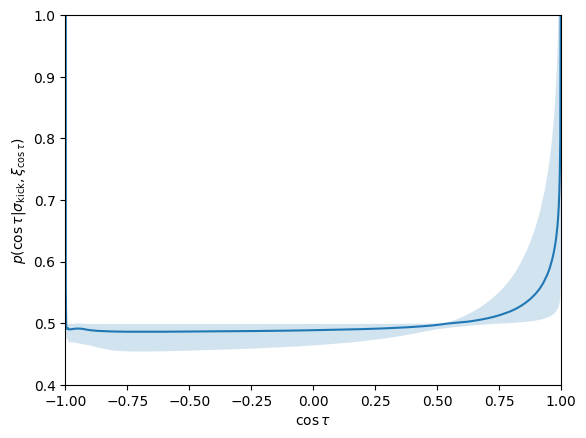

In [57]:
from plots import add_ppd

fig, ax = plt.subplots()
add_ppd(cts, p_ct, ax, color='C0', fill=True, quantiles=[(0.05, 0.95)], alpha=0.2)

ax.set_ylabel(r'$p(\cos \tau | \sigma_{\rm kick}, \xi_{\cos \tau})$')
ax.set_xlabel(r'$\cos \tau$')

ax.set_xlim(-1, 1)
ax.set_ylim(0.4, 1);

We can also plot the inferred kick distribution!

In [58]:
def maxwellian(u, sigma):
    return jnp.sqrt(2 / jnp.pi) / sigma**3 * u**2 * jnp.exp(-u**2 / 2 / sigma**2)

In [59]:
us = jnp.linspace(0, 5, 1_000)
p_kick = jax.vmap(lambda x: maxwellian(us, x))(samples_dict['sigma_kick'])

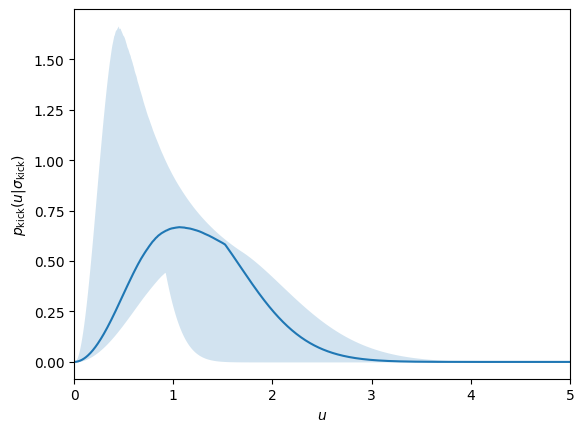

In [61]:
from plots import add_ppd

fig, ax = plt.subplots()
add_ppd(us, p_kick, ax, color='C0', fill=True, quantiles=[(0.05, 0.95)], alpha=0.2)

ax.set_ylabel(r'$p_{\rm kick}(u | \sigma_{\rm kick})$')
ax.set_xlabel(r'$u$')

ax.set_xlim(0, 5);

In [36]:
from variational import estimate_convergence
stats = estimate_convergence(lkl, log_q)

In [37]:
stats['eff'], stats['kss']

(Array(0.00181227, dtype=float64), array(0.92353634))